In [110]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import alpaca_trade_api as tradeapi
import datetime as dt
import pytz
import os
import requests
import matplotlib.pyplot as plt
%matplotlib inline
# import json
# import warnings
# warnings.filterwarnings('ignore')

# Create class to use for simulation

In [2]:
class MCSimulation:
    """
    A Python class for runnning Monte Carlo simulation on portfolio price data. 
    
    ...
    
    Attributes
    ----------
    portfolio_data : pandas.DataFrame
        portfolio dataframe
    weights: list(float)
        portfolio investment breakdown
    nSim: int
        number of samples in simulation
    nTrading: int
        number of trading days to simulate
    simulated_return : pandas.DataFrame
        Simulated data from Monte Carlo
    confidence_interval : pandas.Series
        the 95% confidence intervals for simulated final cumulative returns
        
    """
    
    def __init__(self, portfolio_data, weights="", num_simulation=1000, num_trading_days=252):
        """
        Constructs all the necessary attributes for the MCSimulation object.
        Parameters
        ----------
        portfolio_data: pandas.DataFrame
            DataFrame containing stock price information from Alpaca API
        weights: list(float)
            A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
        num_simulation: int
            Number of simulation samples. DEFAULT: 1000 simulation samples
        num_trading_days: int
            Number of trading days to simulate. DEFAULT: 252 days (1 year of business days)
        """
        
        # Check to make sure that all attributes are set
        if not isinstance(portfolio_data, pd.DataFrame):
            raise TypeError("portfolio_data must be a Pandas DataFrame")
            
        # Set weights if empty, otherwise make sure sum of weights equals one.
        if weights == "":
            num_stocks = len(portfolio_data.columns.get_level_values(0).unique())
            weights = [1.0/num_stocks for s in range(0,num_stocks)]
        else:
            if round(sum(weights),2) < .99:
                raise AttributeError("Sum of portfolio weights must equal one.")
        
        # Calculate daily return if not within dataframe
        if not "daily_return" in portfolio_data.columns.get_level_values(1).unique():
            close_df = portfolio_data.xs('close',level=1,axis=1).pct_change()
            tickers = portfolio_data.columns.get_level_values(0).unique()
            column_names = [(x,"daily_return") for x in tickers]
            close_df.columns = pd.MultiIndex.from_tuples(column_names)
            portfolio_data = portfolio_data.merge(close_df,left_index=True,right_index=True).reindex(columns=tickers,level=0)    
        
        # Set class attributes
        self.portfolio_data = portfolio_data
        self.weights = weights
        self.nSim = num_simulation
        self.nTrading = num_trading_days
        self.simulated_return = ""
        
    def calc_cumulative_return(self):
        """
        Calculates the cumulative return of a stock over time using a Monte Carlo simulation (Brownian motion with drift).
        """
        
        # Get closing prices of each stock
        last_prices = self.portfolio_data.xs('close',level=1,axis=1)[-1:].values.tolist()[0]
        
        # Calculate the mean and standard deviation of daily returns for each stock
        daily_returns = self.portfolio_data.xs('daily_return',level=1,axis=1)
        mean_returns = daily_returns.mean().tolist()
        std_returns = daily_returns.std().tolist()
        
        # Initialize empty Dataframe to hold simulated prices
        portfolio_cumulative_returns = pd.DataFrame()
        
        # Run the simulation of projecting stock prices 'nSim' number of times
        for n in range(self.nSim):
        
            if n % 20 == 0:
                print(f"Running Monte Carlo simulation number {n}...")
        
            # Create a list of lists to contain the simulated values for each stock
            simvals = [[p] for p in last_prices]
    
            # For each stock in our data:
            for s in range(len(last_prices)):

                # Simulate the returns for each trading day
                for i in range(self.nTrading):
        
                    # Calculate the simulated price using the last price within the list
                    simvals[s].append(simvals[s][-1] * (1 + np.random.normal(mean_returns[s], std_returns[s])))
    
            # Calculate the daily returns of simulated prices
            sim_df = pd.DataFrame(simvals).T.pct_change()
    
            # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
            sim_df = sim_df.dot(self.weights)
    
            # Calculate the normalized, cumulative return series
            portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
        
        # Set attribute to use in plotting
        self.simulated_return = portfolio_cumulative_returns
        
        # Calculate 95% confidence intervals for final cumulative returns
        self.confidence_interval = portfolio_cumulative_returns.iloc[-1, :].quantile(q=[0.025, 0.975])
        
        return portfolio_cumulative_returns
    
    def plot_simulation(self):
        """
        Visualizes the simulated stock trajectories using calc_cumulative_return method.
        """ 
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        # Use Pandas plot function to plot the return data
        plt.figure(figsize=(16,9))
        plt.plot(MC_stock_data.simulated_return)
        plot_title = f"{self.nSim} Simulations of Cumulative Portfolio Returns Over the Next {self.nTrading} Trading Days."
        plt.title(plot_title)

        return plt
    
    def plot_distribution(self):
        """
        Visualizes the distribution of cumulative returns simulated using calc_cumulative_return method.
        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
        
        # Use the `plot` function to create a probability distribution histogram of simulated ending prices
        # with markings for a 95% confidence interval
        plt.figure(figsize=(16,9))
        plt.hist(self.simulated_return.iloc[-1, :],bins=10,density=True)
        plt.axvline(self.confidence_interval.iloc[0], color='r')
        plt.axvline(self.confidence_interval.iloc[1], color='r')
        plot_title = f"Distribution of Final Cumuluative Returns Across All {self.nSim} Simulations"
        plt.title(plot_title)

        return plt
    
    def summarize_cumulative_return(self):
        """
        Calculate final summary statistics for Monte Carlo simulated stock data.
        
        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        metrics = self.simulated_return.iloc[-1].describe()
        ci_series = self.confidence_interval
        ci_series.index = ["95% CI Lower","95% CI Upper"]
        return metrics.append(ci_series)

# Part 1 - Personal Finance Planner

Collect Crypto prices using the requests library

In [95]:
# Set current amount of crypto assets
my_btc = 1
my_eth = 5

# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [96]:
# Fetch current BTC price
response_btc = requests.get(btc_url).json()

# Fetch current ETH price
response_eth = requests.get(eth_url).json()

In [97]:
# Compute current value of my crypto
my_btc_value = response_btc['data']['1']['quotes']['USD']['price']*my_btc
my_eth_value = response_eth['data']['1027']['quotes']['USD']['price']*my_eth

In [98]:
# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1 BTC is $50815.00
The current value of your 5 ETH is $21663.45


In [99]:
# Set current amount of shares
my_agg = 225
my_spy = 150

In [100]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [101]:
# Format current date as ISO format
today = pd.Timestamp("2021-12-03", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_portfolio = api.get_barset(
    tickers,
    timeframe,
    limit = 1000,
    end = today
).df

# Preview DataFrame
df_portfolio.tail()

AGG                                           \
                             open      high       low    close      volume   
time                                                                         
2021-11-29 00:00:00-05:00  114.15  114.6000  114.1300  114.550   7604952.0   
2021-11-30 00:00:00-05:00  114.87  115.1074  114.5000  114.765  10559678.0   
2021-12-01 00:00:00-05:00  114.27  114.6400  114.2100  114.610  11306707.0   
2021-12-02 00:00:00-05:00  114.67  114.7900  114.4001  114.610   7507924.0   
2021-12-03 00:00:00-05:00  114.50  115.2400  114.4600  115.060   7279561.0   

                              SPY                                       
                             open    high     low   close       volume  
time                                                                    
2021-11-29 00:00:00-05:00  464.07  466.56  461.73  464.63   68239627.0  
2021-11-30 00:00:00-05:00  462.00  464.03  455.30  455.78  126381409.0  
2021-12-01 00:00:00-05:00  461.64  464.67  450.29  450.53  112177764.0  
2021-12-02 00:00:00-05:00  450.72  459.07  450.31  457.38  109873511.0  
2021-12-03 00:00:00-05:00  459.17  460.30  448.92  453.43  124795750.0

In [102]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio.iloc[-1]['AGG']['close'])
spy_close_price = float(df_portfolio.iloc[-1]['SPY']['close'])
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $115.06
Current SPY closing price: $453.43


In [103]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 150 SPY shares is $68014.50
The current value of your 225 AGG shares is $25888.50


In [108]:
# Set monthly household income
monthly_income = 10000

# Consolidate financial assets data
combined_assets = ['Crypto', 'Shares']
amount = [round((my_btc_value + my_eth_value), 2), (my_agg_value + my_spy_value)]
# Create savings DataFrame
df_savings = pd.DataFrame({'Amount': amount}, index=combined_assets)

# Display savings DataFrame
display(df_savings)

,Amount
Crypto,72478.45
Shares,93903.00


In [109]:
# Set ideal emergency fund
emergency_fund = monthly_income * 6

# Calculate total amount of savings
savings = (my_btc_value + my_eth_value) + (my_agg_value + my_spy_value)

# Validate saving health
if savings > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
elif savings == emergency_fund:
    print("Congratulations! You have reached your financial goal")
elif savings < emergency_fund:
    print(f"You are ${emergency_fund - savings} away from reaching your financial goal")

Congratulations! You have enough money in your emergency fund.


# Part 2 - Retirement Planning

Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-12-05', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-12-05', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    limit = 1000,
    start = start_date,
    end = end_date
).df

# Display sample data
df_stock_data.head()

AGG                                        SPY  \
                             open    high       low   close   volume    open   
time                                                                           
2017-12-14 00:00:00-05:00  109.31  109.51  109.2300  109.45  3698172  267.12   
2017-12-15 00:00:00-05:00  109.42  109.55  109.3150  109.47  2034072  265.45   
2017-12-18 00:00:00-05:00  109.47  109.47  109.2500  109.31  3090761  268.08   
2017-12-19 00:00:00-05:00  109.14  109.16  108.8900  109.00  2583809  268.48   
2017-12-20 00:00:00-05:00  108.75  108.88  108.7059  108.77  3123756  268.25   

                                                             
                             high     low   close    volume  
time                                                         
2017-12-14 00:00:00-05:00  267.22  265.60  265.67  57343318  
2017-12-15 00:00:00-05:00  267.04  265.39  266.53  59269913  
2017-12-18 00:00:00-05:00  268.60  267.98  268.18  45691370  
2017-12-19 00:00:00-05:00  268.53  267.09  267.22  46990895  
2017-12-20 00:00:00-05:00  268.33  266.69  267.04  42133908

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stock_data = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.6, .4],
    num_simulation = 10000,
    num_trading_days = 252*30
)

# Printing the simulation input data
MC_stock_data.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
time                                                                   
2017-12-14 00:00:00-05:00  109.31  109.51  109.2300  109.45  3698172   
2017-12-15 00:00:00-05:00  109.42  109.55  109.3150  109.47  2034072   
2017-12-18 00:00:00-05:00  109.47  109.47  109.2500  109.31  3090761   
2017-12-19 00:00:00-05:00  109.14  109.16  108.8900  109.00  2583809   
2017-12-20 00:00:00-05:00  108.75  108.88  108.7059  108.77  3123756   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2017-12-14 00:00:00-05:00          NaN  267.12  267.22  265.60  265.67   
2017-12-15 00:00:00-05:00     0.000183  265.45  267.04  265.39  266.53   
2017-12-18 00:00:00-05:00    -0.001462  268.08  268.60  267.98  268.18   
2017-12-19 00:00:00-05:00    -0.002836  268.48  268.53  267.09  267.22   
2017-12-20 00:00:00-05:00    -0.002110  268.25  268.33  266.69  267.04   

                                                  
                             volume daily_return  
time                                              
2017-12-14 00:00:00-05:00  57343318          NaN  
2017-12-15 00:00:00-05:00  59269913     0.003237  
2017-12-18 00:00:00-05:00  45691370     0.006191  
2017-12-19 00:00:00-05:00  46990895    -0.003580  
2017-12-20 00:00:00-05:00  42133908    -0.000674

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stock_data.calc_cumulative_return()

Running Monte Carlo simulation number 0...
Running Monte Carlo simulation number 20...
Running Monte Carlo simulation number 40...
Running Monte Carlo simulation number 60...
Running Monte Carlo simulation number 80...
Running Monte Carlo simulation number 100...
Running Monte Carlo simulation number 120...
Running Monte Carlo simulation number 140...
Running Monte Carlo simulation number 160...
Running Monte Carlo simulation number 180...
Running Monte Carlo simulation number 200...
Running Monte Carlo simulation number 220...
Running Monte Carlo simulation number 240...
Running Monte Carlo simulation number 260...
Running Monte Carlo simulation number 280...
Running Monte Carlo simulation number 300...
Running Monte Carlo simulation number 320...
Running Monte Carlo simulation number 340...
Running Monte Carlo simulation number 360...
Running Monte Carlo simulation number 380...
Running Monte Carlo simulation number 400...
Running Monte Carlo simulation number 420...
Running Monte Ca

Running Monte Carlo simulation number 3600...
Running Monte Carlo simulation number 3620...
Running Monte Carlo simulation number 3640...
Running Monte Carlo simulation number 3660...
Running Monte Carlo simulation number 3680...
Running Monte Carlo simulation number 3700...
Running Monte Carlo simulation number 3720...
Running Monte Carlo simulation number 3740...
Running Monte Carlo simulation number 3760...
Running Monte Carlo simulation number 3780...
Running Monte Carlo simulation number 3800...
Running Monte Carlo simulation number 3820...
Running Monte Carlo simulation number 3840...
Running Monte Carlo simulation number 3860...
Running Monte Carlo simulation number 3880...
Running Monte Carlo simulation number 3900...
Running Monte Carlo simulation number 3920...
Running Monte Carlo simulation number 3940...
Running Monte Carlo simulation number 3960...
Running Monte Carlo simulation number 3980...
Running Monte Carlo simulation number 4000...
Running Monte Carlo simulation num

Running Monte Carlo simulation number 7180...
Running Monte Carlo simulation number 7200...
Running Monte Carlo simulation number 7220...
Running Monte Carlo simulation number 7240...
Running Monte Carlo simulation number 7260...
Running Monte Carlo simulation number 7280...
Running Monte Carlo simulation number 7300...
Running Monte Carlo simulation number 7320...
Running Monte Carlo simulation number 7340...
Running Monte Carlo simulation number 7360...
Running Monte Carlo simulation number 7380...
Running Monte Carlo simulation number 7400...
Running Monte Carlo simulation number 7420...
Running Monte Carlo simulation number 7440...
Running Monte Carlo simulation number 7460...
Running Monte Carlo simulation number 7480...
Running Monte Carlo simulation number 7500...
Running Monte Carlo simulation number 7520...
Running Monte Carlo simulation number 7540...
Running Monte Carlo simulation number 7560...
Running Monte Carlo simulation number 7580...
Running Monte Carlo simulation num

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991579,1.002976,1.000793,0.995067,0.997478,0.998624,1.005605,1.000790,1.005566,1.003011,...,1.004330,1.003151,0.999302,0.998075,1.005564,0.999234,1.011327,0.997900,1.003730,1.003003
2,0.987509,1.003486,0.992173,0.994968,0.991850,0.996657,1.004433,0.996725,0.999752,1.010046,...,1.003055,1.005143,0.999623,0.997969,1.009423,1.000936,1.016713,0.993688,1.003955,0.999266
3,0.993285,1.013853,0.989844,0.993830,0.998107,1.001294,1.000091,0.994533,0.999626,1.020828,...,1.006277,1.010200,1.006410,0.997529,1.000884,0.998528,1.020309,0.979820,0.988001,0.992324
4,0.996306,1.029062,0.994360,0.993331,0.992275,0.994946,0.992247,0.988797,0.996676,1.021902,...,1.006169,1.003457,1.008433,0.996448,0.989445,1.003467,1.009364,0.981665,0.990133,0.989001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,4.209206,4.736989,3.090399,11.881969,4.260678,3.189181,13.391184,17.372979,3.085226,11.611490,...,14.998627,11.031913,17.641641,10.137105,8.877898,5.323700,11.574338,10.664533,4.202970,16.397155
7557,4.204141,4.749069,3.097465,11.859009,4.298946,3.200938,13.440706,17.338702,3.109211,11.601617,...,15.053506,11.073700,17.622069,10.207412,8.979087,5.292388,11.481442,10.613604,4.192138,16.289104
7558,4.262489,4.771928,3.094932,11.955384,4.247971,3.227945,13.397848,17.342449,3.115669,11.574633,...,15.161197,11.091802,17.471723,10.141587,9.039942,5.303063,11.388071,10.555548,4.197765,16.191274
7559,4.259468,4.773261,3.115259,11.986481,4.255808,3.246526,13.435140,17.373298,3.102629,11.654239,...,15.178900,11.153254,17.677846,10.199416,8.983625,5.293632,11.236448,10.487693,4.237518,16.170887


<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

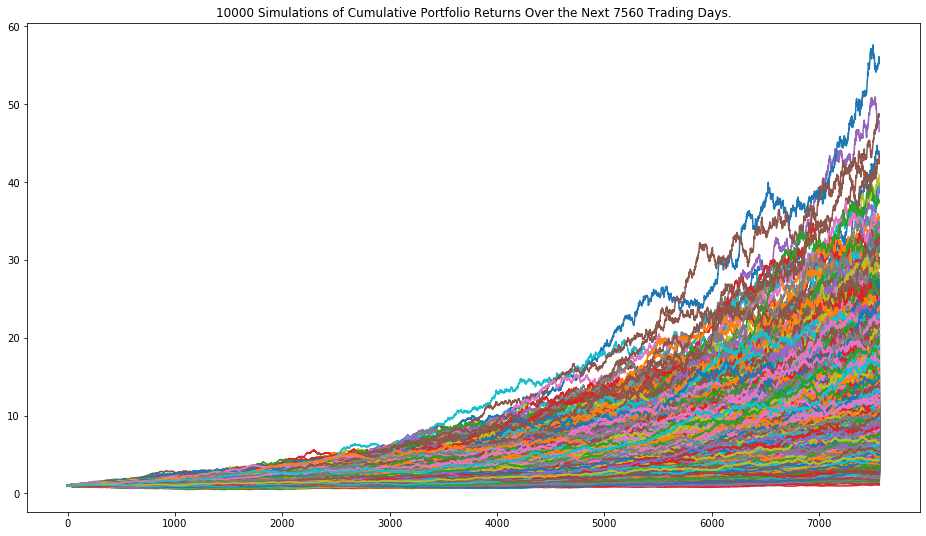

In [19]:
# Plot simulation outcomes
line_plot = MC_stock_data.plot_simulation()
line_plot

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

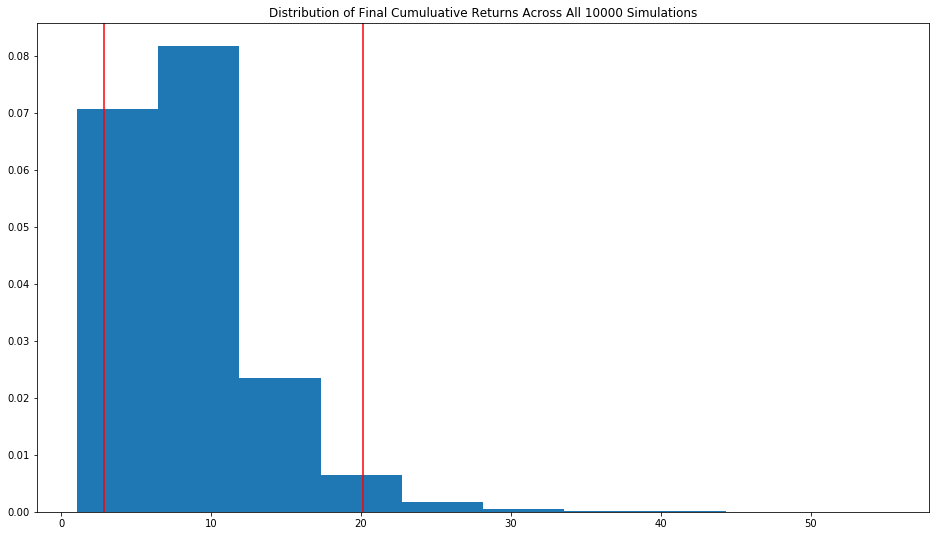

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_stock_data.plot_distribution()
dist_plot

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_stock_data.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           10000.000000
mean                8.528893
std                 4.560906
min                 1.069737
25%                 5.391758
50%                 7.538941
75%                10.418528
max                55.216323
95% CI Lower        2.861543
95% CI Upper       20.161231
Name: 7560, dtype: float64


In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $57230.87 and $403224.62


In [23]:
# Set initial investment
initial_investment = round(20000 * 1.5)

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 30 years will end within in the range of $85846.3 and $604836.93


In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_retirement_5 = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.6, .4],
    num_simulation = 10000,
    num_trading_days = 252*5
)

Running Monte Carlo simulation number 0...
Running Monte Carlo simulation number 20...
Running Monte Carlo simulation number 40...
Running Monte Carlo simulation number 60...
Running Monte Carlo simulation number 80...
Running Monte Carlo simulation number 100...
Running Monte Carlo simulation number 120...
Running Monte Carlo simulation number 140...
Running Monte Carlo simulation number 160...
Running Monte Carlo simulation number 180...
Running Monte Carlo simulation number 200...
Running Monte Carlo simulation number 220...
Running Monte Carlo simulation number 240...
Running Monte Carlo simulation number 260...
Running Monte Carlo simulation number 280...
Running Monte Carlo simulation number 300...
Running Monte Carlo simulation number 320...
Running Monte Carlo simulation number 340...
Running Monte Carlo simulation number 360...
Running Monte Carlo simulation number 380...
Running Monte Carlo simulation number 400...
Running Monte Carlo simulation number 420...
Running Monte Ca

Running Monte Carlo simulation number 3600...
Running Monte Carlo simulation number 3620...
Running Monte Carlo simulation number 3640...
Running Monte Carlo simulation number 3660...
Running Monte Carlo simulation number 3680...
Running Monte Carlo simulation number 3700...
Running Monte Carlo simulation number 3720...
Running Monte Carlo simulation number 3740...
Running Monte Carlo simulation number 3760...
Running Monte Carlo simulation number 3780...
Running Monte Carlo simulation number 3800...
Running Monte Carlo simulation number 3820...
Running Monte Carlo simulation number 3840...
Running Monte Carlo simulation number 3860...
Running Monte Carlo simulation number 3880...
Running Monte Carlo simulation number 3900...
Running Monte Carlo simulation number 3920...
Running Monte Carlo simulation number 3940...
Running Monte Carlo simulation number 3960...
Running Monte Carlo simulation number 3980...
Running Monte Carlo simulation number 4000...
Running Monte Carlo simulation num

Running Monte Carlo simulation number 7180...
Running Monte Carlo simulation number 7200...
Running Monte Carlo simulation number 7220...
Running Monte Carlo simulation number 7240...
Running Monte Carlo simulation number 7260...
Running Monte Carlo simulation number 7280...
Running Monte Carlo simulation number 7300...
Running Monte Carlo simulation number 7320...
Running Monte Carlo simulation number 7340...
Running Monte Carlo simulation number 7360...
Running Monte Carlo simulation number 7380...
Running Monte Carlo simulation number 7400...
Running Monte Carlo simulation number 7420...
Running Monte Carlo simulation number 7440...
Running Monte Carlo simulation number 7460...
Running Monte Carlo simulation number 7480...
Running Monte Carlo simulation number 7500...
Running Monte Carlo simulation number 7520...
Running Monte Carlo simulation number 7540...
Running Monte Carlo simulation number 7560...
Running Monte Carlo simulation number 7580...
Running Monte Carlo simulation num

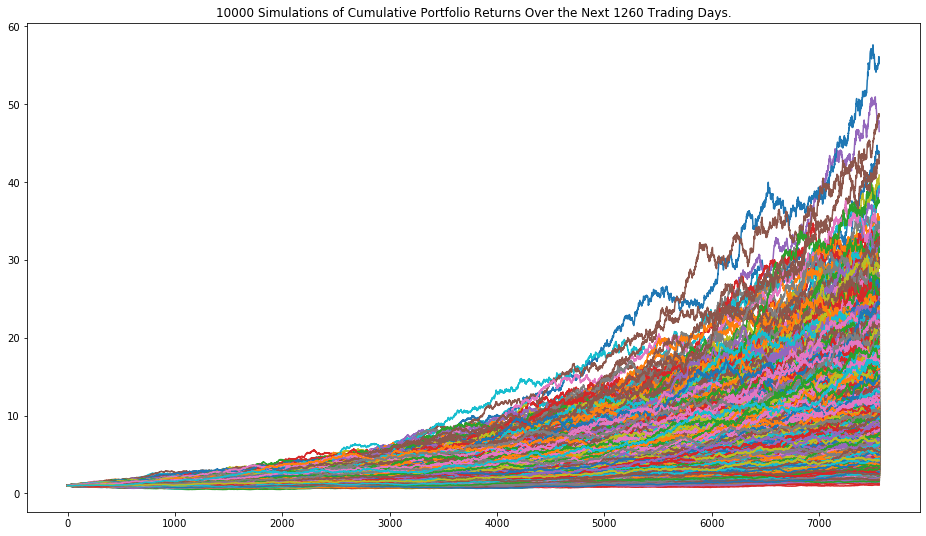

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_retirement_5.calc_cumulative_return()

# Plot simulation outcomes
retirement_5_plot = MC_retirement_5.plot_simulation()

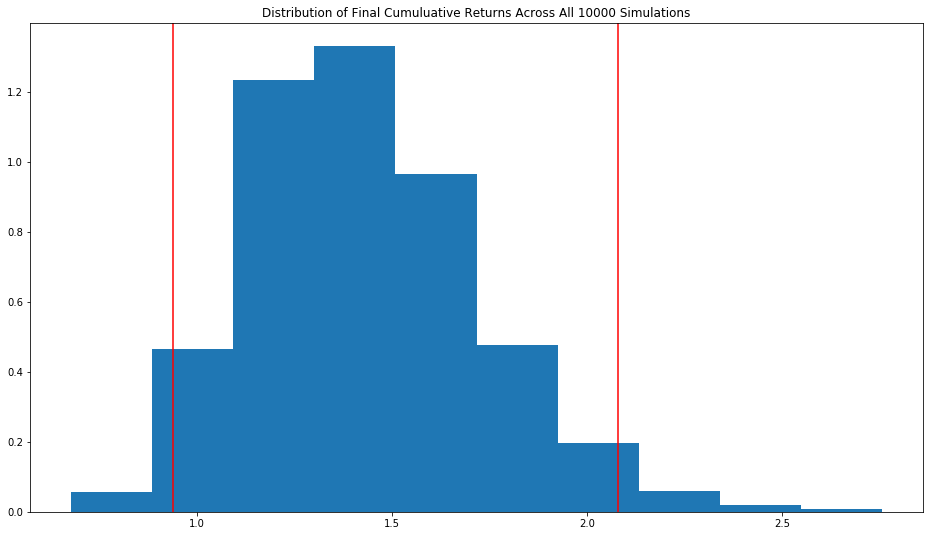

In [26]:
# Plot probability distribution and confidence intervals
dist_retirement_5 = MC_retirement_5.plot_distribution()

In [27]:
# Fetch summary statistics from the Monte Carlo simulation results
retirement_5_tbl = MC_retirement_5.summarize_cumulative_return()

# Print summary statistics
print(retirement_5_tbl)

count           10000.000000
mean                1.427533
std                 0.292474
min                 0.676617
25%                 1.214013
50%                 1.396400
75%                 1.607726
max                 2.756325
95% CI Lower        0.938280
95% CI Upper        2.079753
Name: 1260, dtype: float64


In [28]:
# Set initial investment
initial_investment = 50000 

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_upper_five = round(tbl[8]*initial_investment,2)
ci_lower_five = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $50000 in the portfolio over the next 5 years will end within in the range of $1008061.54 and $143077.17


In [29]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_retirement_10 = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.8, .2],
    num_simulation = 10000,
    num_trading_days = 252*10
)

Running Monte Carlo simulation number 0...
Running Monte Carlo simulation number 20...
Running Monte Carlo simulation number 40...
Running Monte Carlo simulation number 60...
Running Monte Carlo simulation number 80...
Running Monte Carlo simulation number 100...
Running Monte Carlo simulation number 120...
Running Monte Carlo simulation number 140...
Running Monte Carlo simulation number 160...
Running Monte Carlo simulation number 180...
Running Monte Carlo simulation number 200...
Running Monte Carlo simulation number 220...
Running Monte Carlo simulation number 240...
Running Monte Carlo simulation number 260...
Running Monte Carlo simulation number 280...
Running Monte Carlo simulation number 300...
Running Monte Carlo simulation number 320...
Running Monte Carlo simulation number 340...
Running Monte Carlo simulation number 360...
Running Monte Carlo simulation number 380...
Running Monte Carlo simulation number 400...
Running Monte Carlo simulation number 420...
Running Monte Ca

Running Monte Carlo simulation number 3600...
Running Monte Carlo simulation number 3620...
Running Monte Carlo simulation number 3640...
Running Monte Carlo simulation number 3660...
Running Monte Carlo simulation number 3680...
Running Monte Carlo simulation number 3700...
Running Monte Carlo simulation number 3720...
Running Monte Carlo simulation number 3740...
Running Monte Carlo simulation number 3760...
Running Monte Carlo simulation number 3780...
Running Monte Carlo simulation number 3800...
Running Monte Carlo simulation number 3820...
Running Monte Carlo simulation number 3840...
Running Monte Carlo simulation number 3860...
Running Monte Carlo simulation number 3880...
Running Monte Carlo simulation number 3900...
Running Monte Carlo simulation number 3920...
Running Monte Carlo simulation number 3940...
Running Monte Carlo simulation number 3960...
Running Monte Carlo simulation number 3980...
Running Monte Carlo simulation number 4000...
Running Monte Carlo simulation num

Running Monte Carlo simulation number 7180...
Running Monte Carlo simulation number 7200...
Running Monte Carlo simulation number 7220...
Running Monte Carlo simulation number 7240...
Running Monte Carlo simulation number 7260...
Running Monte Carlo simulation number 7280...
Running Monte Carlo simulation number 7300...
Running Monte Carlo simulation number 7320...
Running Monte Carlo simulation number 7340...
Running Monte Carlo simulation number 7360...
Running Monte Carlo simulation number 7380...
Running Monte Carlo simulation number 7400...
Running Monte Carlo simulation number 7420...
Running Monte Carlo simulation number 7440...
Running Monte Carlo simulation number 7460...
Running Monte Carlo simulation number 7480...
Running Monte Carlo simulation number 7500...
Running Monte Carlo simulation number 7520...
Running Monte Carlo simulation number 7540...
Running Monte Carlo simulation number 7560...
Running Monte Carlo simulation number 7580...
Running Monte Carlo simulation num

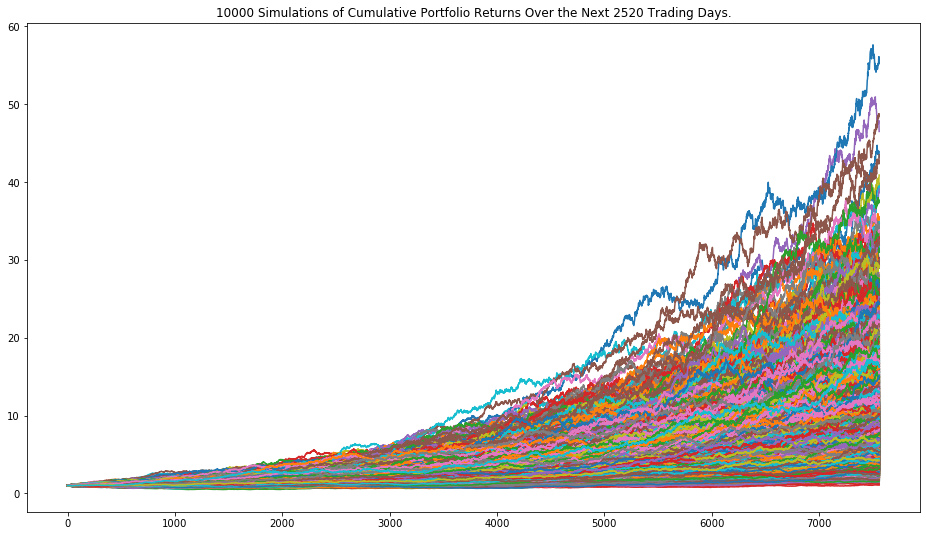

In [30]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_retirement_10.calc_cumulative_return()

# Plot simulation outcomes
plot_retirement_10 = MC_retirement_10.plot_simulation()

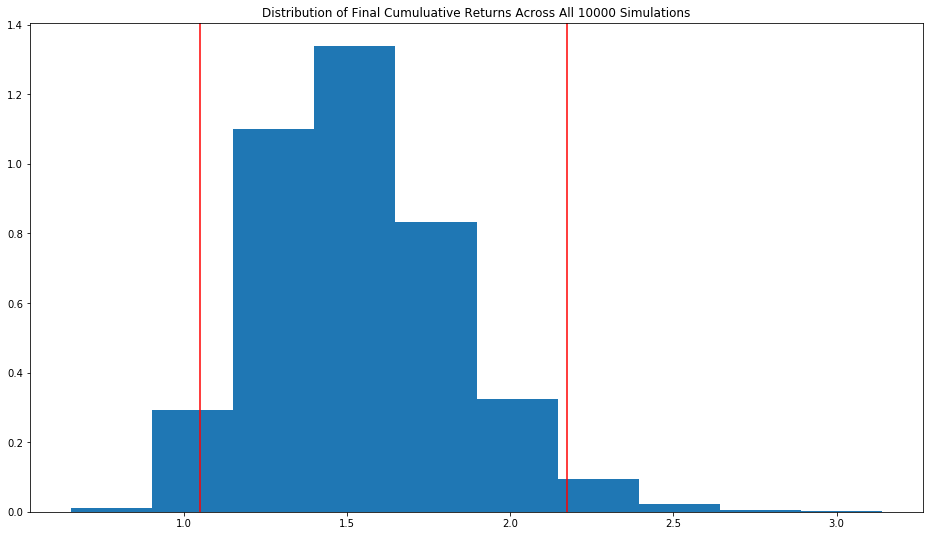

In [31]:
# Plot probability distribution and confidence intervals
dist_retirement_10 = MC_retirement_10.plot_distribution()

In [32]:
# Fetch summary statistics from the Monte Carlo simulation results
retirement_10_tbl = MC_retirement_10.summarize_cumulative_return()

# Print summary statistics
print(retirement_10_tbl)

count           10000.000000
mean                1.534019
std                 0.289857
min                 0.652948
25%                 1.328020
50%                 1.506298
75%                 1.710332
max                 3.140723
95% CI Lower        1.050276
95% CI Upper        2.175339
Name: 2520, dtype: float64


In [33]:
# Set initial investment
initial_investment = 50000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_upper_ten = round(tbl[8]*initial_investment,2)
ci_lower_ten = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $50000 in the portfolio over the next 10 years will end within in the range of $1008061.54 and $143077.17
